In [4]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "data_csv/evict_orig.csv"

In [6]:
df = pd.read_csv(data_path)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 91 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GEOID                       184 non-null    int64  
 1   2020_eviction               184 non-null    float64
 2   2021_eviction               184 non-null    float64
 3   2022_eviction               184 non-null    float64
 4   2023_eviction               184 non-null    float64
 5   own_occ_rate                184 non-null    float64
 6   corp_own_rate               184 non-null    float64
 7   median_yearbuilt            184 non-null    float64
 8   median_price                184 non-null    float64
 9   median_prslpr               184 non-null    float64
 10  mortgage                    184 non-null    float64
 11  median_totrooms             184 non-null    float64
 12  median_bathrooms            184 non-null    int64  
 13  median_bedrooms             184 non

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 25 to 181
Data columns (total 93 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GEOID                       178 non-null    object 
 1   2020_eviction               178 non-null    float64
 2   2021_eviction               178 non-null    float64
 3   2022_eviction               178 non-null    float64
 4   2023_eviction               178 non-null    float64
 5   own_occ_rate                178 non-null    float64
 6   corp_own_rate               178 non-null    float64
 7   median_yearbuilt            178 non-null    float64
 8   median_price                178 non-null    float64
 9   median_prslpr               178 non-null    float64
 10  mortgage                    178 non-null    float64
 11  median_totrooms             178 non-null    float64
 12  median_bathrooms            178 non-null    int64  
 13  median_bedrooms             178 non-nul

<Figure size 1200x600 with 0 Axes>

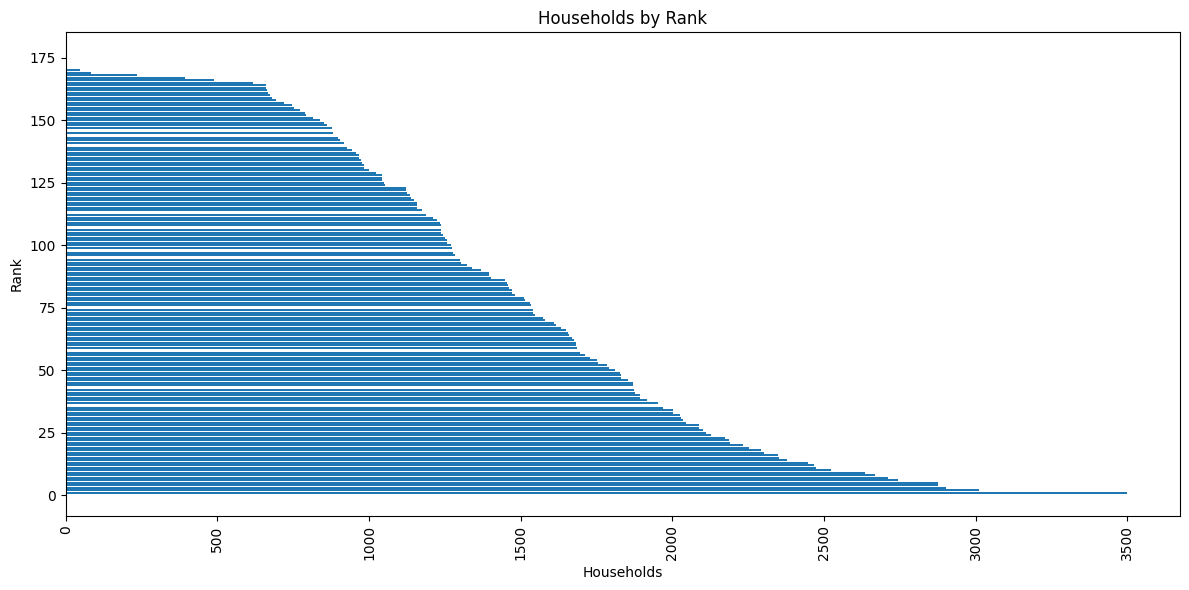

In [8]:
# first filter out GEOID's that don't start with 25025 --> these are not in Boston
# turn GEOID into string
df['GEOID'] = df['GEOID'].astype(str)
df = df[df['GEOID'].str.startswith('25025')]

print(df.info())

# get the population (column 'pop') of each row
# and plot as a ranked bar chart

df['pop'] = df['pop'].astype(int)
df['pop_rank'] = df['pop'].rank(ascending=False)
df['pop_rank'] = df['pop_rank'].astype(int)
# sort by pop_rank
df = df.sort_values(by='pop_rank', ascending=True)
# plot the pop_rank
plt.figure(figsize=(12, 6))
plt.barh(df['pop_rank'], df['pop'])
plt.xlabel('Population')
plt.ylabel('Rank')
plt.title('Population by Rank')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig('evict_population_rank.png')

# do the same thing, but for households (`hh` column)
df['hh'] = df['hh'].astype(int)
df['hh_rank'] = df['hh'].rank(ascending=False)
df['hh_rank'] = df['hh_rank'].astype(int)
# sort by hh_rank
df = df.sort_values(by='hh_rank', ascending=True)
# plot the hh_rank
plt.clf()
plt.figure(figsize=(12, 6))
plt.barh(df['hh_rank'], df['hh'])
plt.xlabel('Households')
plt.ylabel('Rank')
plt.title('Households by Rank')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig('evict_households_rank.png')

# print the 15 rows with the least households
keep_cols = ['GEOID', 'pop', 'hh', '2023_eviction', 'corp_own_rate', 'own_occ_rate', 'mhi', 'o_mhi', 'r_mhi']
df_hh_ranked = df[keep_cols].sort_values(by='hh', ascending=True)

print(df_hh_ranked.head(15))

In [9]:
# also remove any rows with GEOID starting with 2502598 (they're barely populated)
df = df[~df['GEOID'].str.startswith('2502598')]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, 25 to 27
Data columns (total 93 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GEOID                       167 non-null    object 
 1   2020_eviction               167 non-null    float64
 2   2021_eviction               167 non-null    float64
 3   2022_eviction               167 non-null    float64
 4   2023_eviction               167 non-null    float64
 5   own_occ_rate                167 non-null    float64
 6   corp_own_rate               167 non-null    float64
 7   median_yearbuilt            167 non-null    float64
 8   median_price                167 non-null    float64
 9   median_prslpr               167 non-null    float64
 10  mortgage                    167 non-null    float64
 11  median_totrooms             167 non-null    float64
 12  median_bathrooms            167 non-null    int64  
 13  median_bedrooms             167 non-null

In [10]:
# rankings we're interested in correlating
# - eviction rate: (2023_eviction / (hh * (1 - own_occ_rate)) * 100
# - corporate ownership rate: corp_own_rate
# - median household income: mhi
# - median renter household income: r_mhi
# - non-white races percentage: (pop - nhwhi) / pop * 100

# get these columns, (along with the GEOID and operand columns)
# and save to a new dataframe
df['eviction_rate'] = df['2023_eviction'] / (df['hh'] * (1 - df['own_occ_rate'])) * 100
df['non_white_rate'] = (df['pop'] - df['nhwhi']) / df['pop'] * 100

# renter household count
df["r_hh"] = (df['hh'] * (1 - df['own_occ_rate'])).astype(int)

# # save to csv
# df_splice.to_csv('evict_spliced_ranked_by_eviction_rate.csv', index=False)

# do a sanity check
# what's the average eviction rate?
# (sum the eviction counts, and divide by the sum of the households)
# get the sum of the eviction counts
eviction_count_sum = df['2023_eviction'].sum()
# get the sum of the households
household_count_sum = df['r_hh'].sum()

# around 3% should make sense
print(f"Average eviction rate: {eviction_count_sum / household_count_sum * 100:.2f}%") # output: 2.80%

# do some correlation analysis --> how are the variables we're interested in correlated
key_cols = ['eviction_rate', 'corp_own_rate', 'mhi', 'r_mhi', 'non_white_rate']

# 'spearman' for ranking correlation
corr = df[key_cols].corr(method='spearman')

# save to csv
corr.to_csv('data_csv/evict_correlation_matrix.csv', index=True)
print("\nCorrelations:")
print(corr)

Average eviction rate: 2.80%

Correlations:
                eviction_rate  corp_own_rate       mhi     r_mhi  \
eviction_rate        1.000000      -0.015871 -0.493732 -0.560370   
corp_own_rate       -0.015871       1.000000 -0.328765 -0.205461   
mhi                 -0.493732      -0.328765  1.000000  0.898656   
r_mhi               -0.560370      -0.205461  0.898656  1.000000   
non_white_rate       0.786381      -0.066263 -0.648515 -0.655466   

                non_white_rate  
eviction_rate         0.786381  
corp_own_rate        -0.066263  
mhi                  -0.648515  
r_mhi                -0.655466  
non_white_rate        1.000000  


In [14]:
# get rankings of the columns we're interested in
# and save to a new dataframe
df["rank_eviction_rate"] = df['eviction_rate'].rank(ascending=False) # highest first
df["rank_corp_own_rate"] = df['corp_own_rate'].rank(ascending=False) # highest first
df["rank_mhi"] = df['mhi'].rank(ascending=True) # lowest first
df["rank_r_mhi"] = df['r_mhi'].rank(ascending=True) # lowest first
df["rank_non_white_rate"] = df['non_white_rate'].rank(ascending=False) # highest first

# get the racial makeup of the population, include categories {white, black, hispanic, asian, other}
df["white_rate"] = df["nhwhi"] / df["pop"] * 100
df["black_rate"] = df["nhaa"] / df["pop"] * 100
df["hispanic_rate"] = df["lat"] / df["pop"] * 100
df["asian_rate"] = df["nhas"] / df["pop"] * 100
df["othr_race_rate"] = 100 - df["white_rate"] - df["black_rate"] - df["hispanic_rate"] - df["asian_rate"]

# now output the processed data
keep_cols = [
    "GEOID", # main index
    "2020_eviction", "2021_eviction", "2022_eviction", "2023_eviction", # eviction counts
    "own_occ_rate", "pop", # owner-occupied rate, population
    "hh", "r_hh", # total households, renter households
    "eviction_rate", "rank_eviction_rate", # eviction filing rate (computed with 2023_eviction and r_hh)
    "corp_own_rate", "rank_corp_own_rate", # corporate ownership rate
    "non_white_rate", "rank_non_white_rate", # non-white rate
    "o_mhi", # owner-occupied median household income (for highlighting contrast)
    "mhi", "rank_mhi", # median household income
    "r_mhi", "rank_r_mhi", # median renter household income
    "white_rate", "black_rate", "hispanic_rate", "asian_rate", "othr_race_rate", # racial makeup
]

# save to csv
df_proc = df[keep_cols]

# use the original row order
df_proc = df_proc.sort_index()
df_proc.to_csv('data_csv/evict_processed.csv', index=False)

# save another csv to fill out `neighborhoods` for each GEOID later
df_neighborhoods = df_proc[["GEOID"]]
# add a column for the neighborhood name, initially empty
df_neighborhoods["neighborhood"] = ""

# save to csv
df_neighborhoods.to_csv('data_csv/evict_neighborhoods.csv', index=False)

/tmp/ipykernel_1420848/1158542510.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neighborhoods["neighborhood"] = ""
